In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

plt.rc("font", family="Malgun Gothic")
matplotlib.rcParams["axes.unicode_minus"] = False

In [6]:
train = pd.read_csv('train.csv').drop(columns=['ID'])
test = pd.read_csv('test.csv').drop(columns=['ID'])

In [7]:
drop_cols = [
    # unqiue value <= 1
    "착상 전 유전 검사 사용 여부",
    "난자 채취 경과일", 
    "PGS 시술 여부", 
    "PGD 시술 여부", 
    "불임 원인 - 여성 요인",
    
    # NaN 비율 99% 이상
    '난자 해동 경과일', 
    '불임 원인 - 정자 면역학적 요인', 
    '불임 원인 - 자궁경부 문제',
    
    # 정보가 거의 없는 변수
    '배란 유도 유형',
    
    # Feature Importance == 0
    "불임 원인 - 정자 형태",
    
    '불임 원인 - 정자 운동성', 
    '저장된 신선 난자 수', 
    '동결 배아 사용 여부'
    
    
]

train = train.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)

In [8]:
def process_treatment_type(value):
    """
    특정 시술 유형을 정리하고, 단일 시술과 복합 시술로 구분하며, 데이터가 적은 시술을 'Unknown'으로 변경하는 함수.
    """

    # NaN 처리
    if pd.isna(value): 
        return "Unknown"

    # 공백 제거 및 기본 정리
    value = value.strip().replace(" ", "")

    # 중복 표기 정리 (예: ICSI:ICSI -> ICSI)
    replacements = {
        "ICSI:ICSI": "ICSI",
        "IVF:IVF": "IVF",
        "IVF:ICSI": "ICSI:IVF",  # ICSI:IVF로 통일
        "ICSI/BLASTOCYST:IVF/BLASTOCYST": "ICSI/BLASTOCYST",
        "ICSI/BLASTOCYST :IVF/BLASTOCYST": "ICSI/BLASTOCYST",
        "ICSI/BLASTOCYST:ICSI": "ICSI/BLASTOCYST",
        "IUI:ICI": "IUI"
    }
    for key, val in replacements.items():
        value = value.replace(key, val)

    # Unknown 포함된 경우 정리
    if "Unknown" in value:
        value = value.replace(":Unknown", "").replace("/Unknown", "")

    # 특정 시술 유형을 단일 시술과 복합 시술로 구분
    if ("/" in value) or (":" in value):  
        return "복합 시술"

    # 데이터 개수가 적은 특정 시술 유형을 'Unknown'으로 변경
    low_count_treatments = {"FER", "GIFT", "GenericDI", "ICI", "IVI"}
    if value in low_count_treatments:
        return "Unknown"

    return value

def categorize_embryo_reason(reason):
    """
    배아 생성 주요 이유를 '현재 시술용', '저장용', '기증용', '복합 시술'로 변환하는 함수.
    """
    if pd.isna(reason):  # 결측치는 현재 시술용으로 간주
        return "현재 시술용"
    
    # 저장용: '배아 저장용'과 '난자 저장용'을 묶음
    if reason in ["배아 저장용", "난자 저장용"]:
        return "저장용"

    # 단일 목적 (현재 시술, 기증)인 경우 그대로 유지
    if reason in ["현재 시술용", "기증용"]:
        return reason

    # 위 3가지 경우가 아닌 모든 경우는 "복합 시술"로 처리
    return "복합 시술"

In [9]:
import re 

def df_preprocessing(df):
    """ Preprocessing of the dataframe"""
    new_df = df.copy(deep=True)
    
    # 횟수 변수 : 성능 동일
    count_columns = [
        "총 시술 횟수", "IVF 시술 횟수", "DI 시술 횟수", "클리닉 내 총 시술 횟수",
        "총 임신 횟수", "IVF 임신 횟수", "DI 임신 횟수",
        "총 출산 횟수", "IVF 출산 횟수", "DI 출산 횟수"]
    for col in count_columns:
        new_df[col] = new_df[col].replace("6회 이상", "6").str.replace("회", "").astype(int)
        
        
    # 시술 당시 나이 변환 (중간값 사용) : 나이가 어릴 수록 성공률 높아지기에 이를 수치변수로 변환
    age_map_surgery = {
        "만18-34세": 26,
        "만35-37세": 36,
        "만38-39세": 38,
        "만40-42세": 41,
        "만43-44세": 43,
        "만45-50세": 47,
        # "알 수 없음": -1
        "알 수 없음": 36 # median으로 채우기
    }
    new_df["시술 당시 나이"] = new_df["시술 당시 나이"].map(age_map_surgery)
    
    # 난자 기증자 나이 변환 
    age_map_donor = {
        "알 수 없음": -1,
        "만20세 이하": 18,
        "만21-25세": 23,
        "만26-30세": 28,
        "만31-35세": 33
    }
    new_df["난자 기증자 나이"] = new_df["난자 기증자 나이"].map(age_map_donor)


    # 특정 시술 유형 
    new_df["특정 시술 유형"] = new_df["특정 시술 유형"].apply(process_treatment_type)
    
    # 클리닉 외 총 시술 횟수 
    new_df['클리닉 외 총 시술 횟수'] = new_df['총 시술 횟수'] - new_df['클리닉 내 총 시술 횟수']
    
    # 배아 사용률 (Fold 5 빼고 모두 상승)
    new_df["배아 사용률"] = new_df["이식된 배아 수"] / (new_df["총 생성 배아 수"] + 1)
    
    # 미세 주입률 
    new_df["미세주입률"] = new_df["미세주입된 난자 수"] / (new_df["총 생성 배아 수"] + 1)
    
    new_df["시술 성공률"] = new_df["총 임신 횟수"] / (new_df["총 시술 횟수"] + 1)  
    new_df["IVF 성공률"] = new_df["IVF 임신 횟수"] / (new_df["IVF 시술 횟수"] + 1)  
    new_df["DI 성공률"] = new_df["DI 임신 횟수"] / (new_df["DI 시술 횟수"] + 1) 
    
    
    new_df["배아 보존율"] = new_df["저장된 배아 수"] / (new_df["총 생성 배아 수"] + 1)  
    new_df["배아 이식률"] = new_df["이식된 배아 수"] / (new_df["총 생성 배아 수"] + 1)  
    new_df["배아 해동률"] = new_df["해동된 배아 수"] / (new_df["저장된 배아 수"] + 1)  
    
    new_df["나이 x 경과 연수"] = new_df["시술 당시 나이"] * new_df["임신 시도 또는 마지막 임신 경과 연수"]
    new_df["나이당 평균 시술 횟수"] = new_df["시술 당시 나이"] / (new_df["총 시술 횟수"] + 1)
    

    # 나이 대비 임신 시도 기간 (임신 준비 기간을 고려)
    # new_df["나이 대비 임신 시도 연수"] = new_df["시술 당시 나이"] / (new_df["임신 시도 또는 마지막 임신 경과 연수"] + 1)

    # 나이 대비 생성된 배아 수 (배아 생성 능력과 관련)
    new_df["나이당 배아 생성 수"] = new_df["시술 당시 나이"] / (new_df["총 생성 배아 수"] + 1)

    # 나이 대비 배아 이식률
    new_df["나이당 배아 이식률"] = new_df["시술 당시 나이"] / (new_df["배아 이식률"] + 1e-5)
    
    # 배아 생성 주요 이유
    new_df["배아 생성 주요 이유"] = new_df["배아 생성 주요 이유"].map(categorize_embryo_reason)
    

    
    return new_df

train = df_preprocessing(train)
test = df_preprocessing(test)

In [10]:
X = train.drop(columns=['임신 성공 여부'], axis=1)
y = train['임신 성공 여부']

In [11]:
categorical_columns = [
    "시술 시기 코드",
    # "시술 당시 나이",
    "시술 유형",
    "특정 시술 유형",
    "배란 자극 여부",
    # "배란 유도 유형",
    "단일 배아 이식 여부",
    # "착상 전 유전 검사 사용 여부",
    "착상 전 유전 진단 사용 여부",
    "남성 주 불임 원인",
    "남성 부 불임 원인",
    "여성 주 불임 원인",
    "여성 부 불임 원인",
    "부부 주 불임 원인",
    "부부 부 불임 원인",
    "불명확 불임 원인",
    "불임 원인 - 난관 질환",
    "불임 원인 - 남성 요인",
    "불임 원인 - 배란 장애",
    # "불임 원인 - 여성 요인",
    # "불임 원인 - 자궁경부 문제",
    "불임 원인 - 자궁내막증",
    "불임 원인 - 정자 농도",
    # "불임 원인 - 정자 면역학적 요인",
    # "불임 원인 - 정자 운동성",
    # "불임 원인 - 정자 형태",
    "배아 생성 주요 이유",
    # "총 시술 횟수",
    # "클리닉 내 총 시술 횟수",
    # "IVF 시술 횟수",
    # "DI 시술 횟수",
    # "총 임신 횟수",
    # "IVF 임신 횟수",
    # "DI 임신 횟수",
    # "총 출산 횟수",
    # "IVF 출산 횟수",
    # "DI 출산 횟수",
    "난자 출처",
    "정자 출처",
    # "난자 기증자 나이",
    "정자 기증자 나이",
    # "동결 배아 사용 여부",
    "신선 배아 사용 여부",
    "기증 배아 사용 여부",
    "대리모 여부",
    # "PGD 시술 여부",
    # "PGS 시술 여부"
]

numeric_columns = [
    "임신 시도 또는 마지막 임신 경과 연수",
    "총 생성 배아 수",
    "미세주입된 난자 수",
    "미세주입에서 생성된 배아 수",
    "이식된 배아 수",
    "미세주입 배아 이식 수",
    "저장된 배아 수",
    "미세주입 후 저장된 배아 수",
    "해동된 배아 수",
    "해동 난자 수",
    "수집된 신선 난자 수",
    # "저장된 신선 난자 수",
    "혼합된 난자 수",
    "파트너 정자와 혼합된 난자 수",
    "기증자 정자와 혼합된 난자 수",
    # "난자 채취 경과일",
    # "난자 해동 경과일",
    "난자 혼합 경과일",
    "배아 이식 경과일",
    "배아 해동 경과일",
    
    # ---- Categorical -> Numerical ----
    "총 시술 횟수",
    "클리닉 내 총 시술 횟수",
    "IVF 시술 횟수",
    "DI 시술 횟수",
    "총 임신 횟수",
    "IVF 임신 횟수",
    "DI 임신 횟수",
    "총 출산 횟수",
    "IVF 출산 횟수",
    "DI 출산 횟수",
    "난자 기증자 나이",
    
    "시술 당시 나이",
    '클리닉 외 총 시술 횟수',
    
    "배아 사용률",
    "미세주입률",
    
    "시술 성공률",
    "IVF 성공률",
    "DI 성공률",
    
    "배아 보존율", 
    "배아 이식률", 
    "배아 해동률",
    
    "나이 x 경과 연수",
    "나이당 평균 시술 횟수",
    
    "나이당 배아 생성 수",
    "나이당 배아 이식률",
    
]

In [12]:
# 카테고리형 컬럼들을 문자열로 변환
for col in categorical_columns:
    X[col] = X[col].astype(str)
    test[col] = test[col].astype(str)

In [13]:
# Ordinal Encoding (XGBoost는 숫자형 데이터를 입력받음)
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train_encoded = X.copy()
X_train_encoded[categorical_columns] = ordinal_encoder.fit_transform(X[categorical_columns])

X_test_encoded = test.copy()
X_test_encoded[categorical_columns] = ordinal_encoder.transform(test[categorical_columns])

In [14]:
# 결측값 처리 (수치형 컬럼)
X_train_encoded[numeric_columns] = X_train_encoded[numeric_columns].fillna(0)
X_test_encoded[numeric_columns] = X_test_encoded[numeric_columns].fillna(0)

## Baseline

In [16]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
import xgboost as xgb

# X_train_encoded와 X_test_encoded를 사용하도록 변경
X = X_train_encoded  # Ordinal Encoding 적용된 데이터
test = X_test_encoded  # 테스트 데이터도 Encoding 적용됨

# K-Fold 설정
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True)

# 결과를 저장할 데이터프레임 생성
results_df = pd.DataFrame(columns=["random_state", "mean_auc", "std_auc"])

for random_state in range(1, 100):
    print(f"Running CV for random_state: {random_state}...")

    # K-Fold 설정에 random_state 추가
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    xgb_params = {
        "n_estimators": 521,
        "learning_rate": 0.06008965519455756,
        "max_depth": 5,
        "subsample": 0.8719000849256723,
        "lambda": 34.35891706023127,
        "alpha": 5.193177125742917,
        "gamma": 0.93279456500174,
        "colsample_bytree": 0.7859055053824342,
        "colsample_bylevel": 0.8296279991276528,
        "min_child_weight": 2,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "early_stopping_rounds": 50,
        "random_state": random_state,
    }

    oof_preds = np.zeros(len(X))
    fold_auc_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f"Training Fold {fold + 1}/{n_splits}...")

        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        # 모델 학습
        model = xgb.XGBClassifier(**xgb_params)
        model.fit(
            X_train_fold,
            y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            verbose=False,
        )

        # 검증 데이터 예측
        val_preds = model.predict_proba(X_val_fold)[:, 1]
        oof_preds[val_idx] = val_preds

        # Fold별 AUC 점수 계산
        fold_auc = roc_auc_score(y_val_fold, val_preds)
        fold_auc_scores.append(fold_auc)
        print(f"Fold {fold + 1} AUC: {fold_auc}")

    # 전체 Fold AUC 평균 계산
    mean_auc = np.mean(fold_auc_scores)
    std_auc = np.std(fold_auc_scores)
    print(f"Mean AUC: {mean_auc} ± {std_auc}")

    # 결과를 데이터프레임에 추가
    results_df = pd.concat(
        [
            results_df,
            pd.DataFrame(
                {
                    "random_state": [random_state],
                    "mean_auc": [mean_auc],
                    "std_auc": [std_auc],
                }
            ),
        ],
        ignore_index=True,
    )

# 결과 데이터프레임 출력
print(results_df)

Running CV for random_state: 1...
Training Fold 1/5...
Fold 1 AUC: 0.7389712161005672
Training Fold 2/5...
Fold 2 AUC: 0.738391918451854
Training Fold 3/5...
Fold 3 AUC: 0.7436461964856425
Training Fold 4/5...
Fold 4 AUC: 0.7436044072580303
Training Fold 5/5...
Fold 5 AUC: 0.7349360777854044
Mean AUC: 0.7399099632162998 ± 0.0033326745461941683
Running CV for random_state: 2...
Training Fold 1/5...
Fold 1 AUC: 0.7423326298100686
Training Fold 2/5...
Fold 2 AUC: 0.7385316459214883
Training Fold 3/5...
Fold 3 AUC: 0.7394467002669809
Training Fold 4/5...
Fold 4 AUC: 0.742055586911438
Training Fold 5/5...
Fold 5 AUC: 0.737637031908358
Mean AUC: 0.7400007189636668 ± 0.0018821487344687314
Running CV for random_state: 3...
Training Fold 1/5...
Fold 1 AUC: 0.7401945921327098
Training Fold 2/5...
Fold 2 AUC: 0.7430574032253621
Training Fold 3/5...
Fold 3 AUC: 0.7415698569095206
Training Fold 4/5...
Fold 4 AUC: 0.73507948237052
Training Fold 5/5...
Fold 5 AUC: 0.7408348372138368
Mean AUC: 0.74014

In [17]:
# mean_auc 값으로 내림차순 정렬
results_df = results_df.sort_values(by="mean_auc", ascending=False)

# 결과 데이터프레임 출력
print(results_df)

# 결과 데이터프레임을 CSV 파일로 저장
results_df.to_csv("cv_results.csv", index=False)

   random_state  mean_auc   std_auc
19           20  0.740421  0.001379
30           31  0.740316  0.002360
62           63  0.740260  0.001337
89           90  0.740222  0.000683
51           52  0.740213  0.000682
..          ...       ...       ...
14           15  0.739825  0.002342
33           34  0.739820  0.002120
48           49  0.739720  0.001585
39           40  0.739717  0.001618
27           28  0.739685  0.002123

[99 rows x 3 columns]


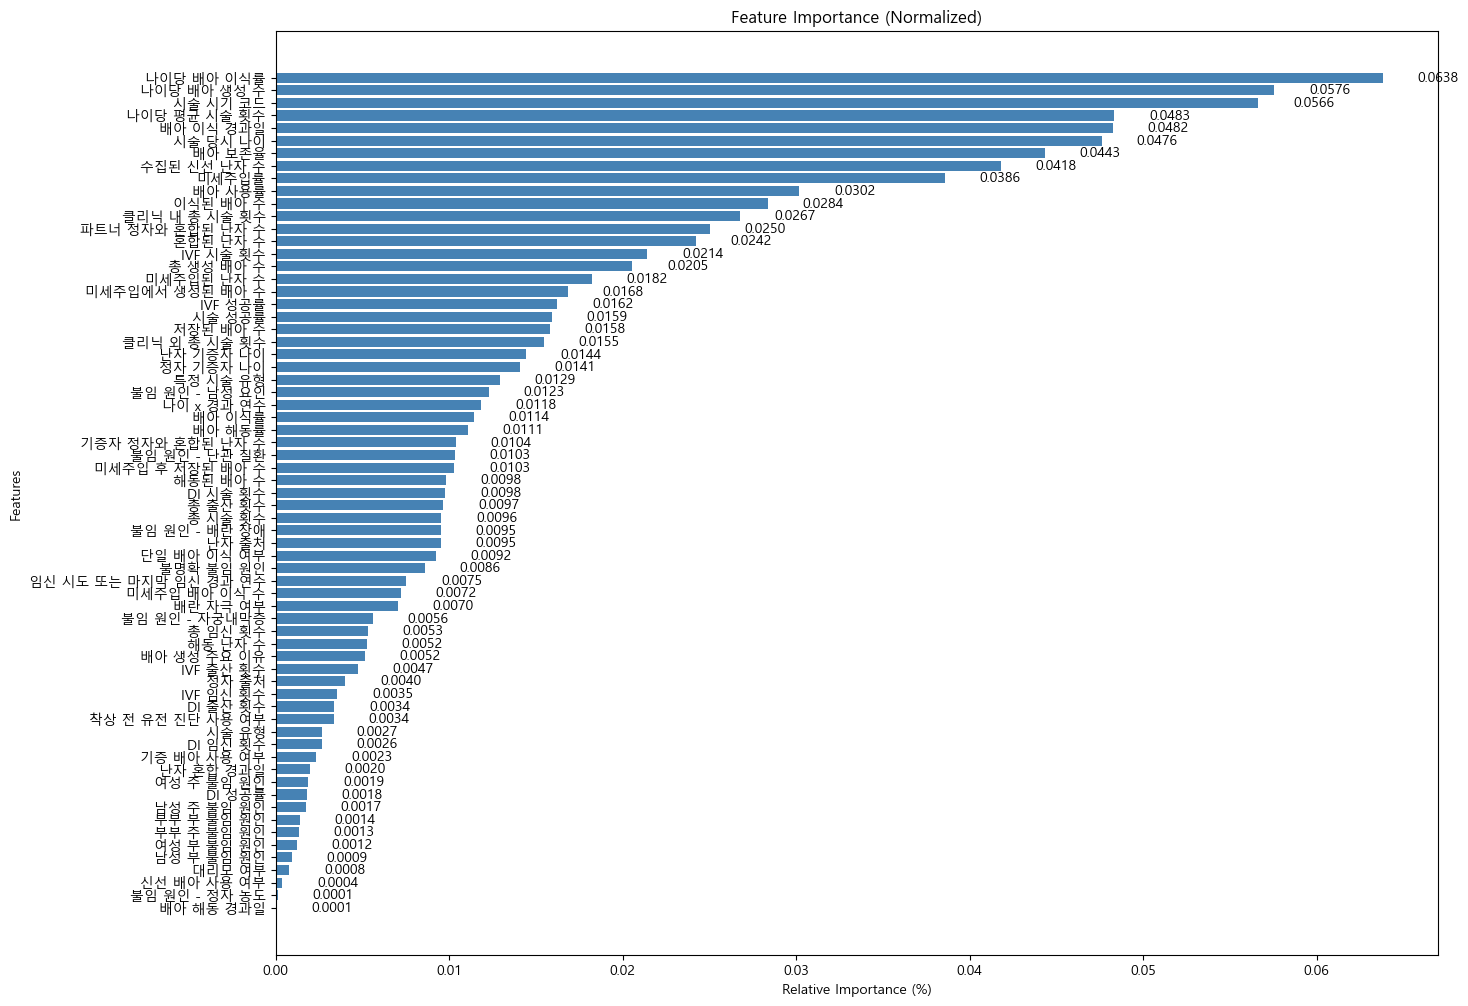

In [98]:
# 6️⃣ Feature Importance 분석
feature_importance_df = feature_importance_df.groupby("Feature").mean().reset_index()
feature_importance_df["Relative Importance"] = feature_importance_df["F Score"] / feature_importance_df["F Score"].sum()
feature_importance_df = feature_importance_df.sort_values(by="Relative Importance", ascending=False)

# 7️⃣ Feature Importance 시각화
plt.figure(figsize=(15, 12))
plt.barh(feature_importance_df["Feature"][:100], feature_importance_df["Relative Importance"][:100], color="steelblue")

# 막대바 옆에 값 표시
for index, value in enumerate(feature_importance_df["Relative Importance"][:100]):
    plt.text(value + 0.002, index, f"{value:.4f}", va='center', fontsize=10)

plt.xlabel("Relative Importance (%)")
plt.ylabel("Features")
plt.title("Feature Importance (Normalized)")
plt.gca().invert_yaxis()  # 상위 Feature를 위로 배치
plt.show()

In [47]:
feature_importance_df['Feature'].tolist()

['나이당 배아 이식률',
 '나이당 평균 시술 횟수',
 '시술 시기 코드',
 '나이당 배아 생성 수',
 '배아 보존율',
 '시술 당시 나이',
 '미세주입률',
 '수집된 신선 난자 수',
 '배아 이식 경과일',
 '배아 사용률',
 '클리닉 내 총 시술 횟수',
 '파트너 정자와 혼합된 난자 수',
 '혼합된 난자 수',
 '총 생성 배아 수',
 'IVF 시술 횟수',
 '미세주입된 난자 수',
 '이식된 배아 수',
 '정자 기증자 나이',
 '시술 성공률',
 '클리닉 외 총 시술 횟수',
 '저장된 배아 수',
 '미세주입에서 생성된 배아 수',
 'IVF 성공률',
 '총 시술 횟수',
 '나이 x 경과 연수',
 '난자 기증자 나이',
 '기증자 정자와 혼합된 난자 수',
 '불임 원인 - 남성 요인',
 '미세주입 후 저장된 배아 수',
 '특정 시술 유형',
 'DI 시술 횟수',
 '해동된 배아 수',
 '불임 원인 - 난관 질환',
 '배아 이식률',
 '총 출산 횟수',
 '배아 해동률',
 '임신 시도 또는 마지막 임신 경과 연수',
 '불임 원인 - 배란 장애',
 '불명확 불임 원인',
 '단일 배아 이식 여부',
 '난자 출처',
 '해동 난자 수',
 '미세주입 배아 이식 수',
 '총 임신 횟수',
 'IVF 출산 횟수',
 '배란 자극 여부',
 '불임 원인 - 자궁내막증',
 'IVF 임신 횟수',
 '배아 생성 주요 이유',
 '정자 출처',
 'DI 성공률',
 '착상 전 유전 진단 사용 여부',
 'DI 출산 횟수',
 '여성 주 불임 원인',
 'DI 임신 횟수',
 '남성 주 불임 원인',
 '기증 배아 사용 여부',
 '부부 주 불임 원인',
 '여성 부 불임 원인',
 '부부 부 불임 원인',
 '난자 혼합 경과일',
 '시술 유형',
 '남성 부 불임 원인',
 '대리모 여부',
 '불임 원인 - 정자 농도',
 '배아 해동 경과일',
 '신선 배아 사용 여부']

## Optuna

In [96]:
import optuna
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

# K-Fold 설정
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

def objective(trial):
    """Optuna 최적화 목적 함수"""
    
    # 최적화할 하이퍼파라미터 범위 설정
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-2, 100.0),  # L2 정규화
        'alpha': trial.suggest_loguniform('alpha', 1e-2, 10.0),  # L1 정규화
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),  # 리프 노드 분할 방지
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'early_stopping_rounds': 50,
        'random_state': 42
    }

    # OOF Predictions
    oof_preds = np.zeros(len(X))
    fold_auc_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        # 모델 학습
        model = xgb.XGBClassifier(**params)
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            verbose=False
        )

        # 검증 데이터 예측
        val_preds = model.predict_proba(X_val_fold)[:, 1]
        oof_preds[val_idx] = val_preds

        # Fold별 AUC 점수 저장
        fold_auc = roc_auc_score(y_val_fold, val_preds)
        fold_auc_scores.append(fold_auc)

    # 평균 AUC
    mean_auc = np.mean(fold_auc_scores)
    std_auc = np.std(fold_auc_scores)  # Fold 간 편차
    min_auc = min(fold_auc_scores)  # 최저 Fold AUC

    # ✨ 최적화 목표: 평균 AUC 증가 + Fold 편차 감소 + 최소 Fold AUC 개선 ✨
    score = mean_auc - (std_auc * 0.5) + (min_auc * 0.2)  # Fold 편차가 크면 패널티 적용

    return score  # 높은 값일수록 좋은 하이퍼파라미터 조합

# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# 최적 파라미터 출력
print("Best params:", study.best_params)

c:\Users\USER\anaconda3\envs\LG_Aimers_5\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-02-26 20:50:18,265] A new study created in memory with name: no-name-66753cee-0fe3-4051-9274-8d4691fb95b1
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_20384\3797700610.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-2, 100.0),  # L2 정규화
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_20384\3797700610.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., 

Best params: {'n_estimators': 521, 'learning_rate': 0.06008965519455756, 'max_depth': 5, 'subsample': 0.8719000849256723, 'colsample_bytree': 0.7859055053824342, 'colsample_bylevel': 0.8296279991276528, 'lambda': 34.35891706023127, 'alpha': 5.193177125742917, 'gamma': 0.93279456500174, 'min_child_weight': 2}


## Submission

In [99]:
sample_submission = pd.read_csv('./open/sample_submission.csv')
# sample_submission['probability'] = pred_proba
sample_submission['probability'] = test_preds

In [100]:
sample_submission

,ID,probability
0,TEST_00000,0.001092
1,TEST_00001,0.001205
2,TEST_00002,0.142900
3,TEST_00003,0.097393
4,TEST_00004,0.513503
...,...,...
90062,TEST_90062,0.001722
90063,TEST_90063,0.292300
90064,TEST_90064,0.517107
90065,TEST_90065,0.189643


In [101]:
sample_submission.to_csv('./baseline_submit_0226.csv', index=False)